In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import zip_longest
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv("force_cases_batch_1_features1.csv")

cols_to_drop = ["jerk_p10", "jerk_p90", "dtheta_min", "dtheta_p10", "F_norm_zcr_per_s"]
df = df.drop(columns=cols_to_drop, errors="ignore")  # errors="ignore" prevents crash if a col is missing

In [3]:
# for i in df.keys():
#     print(i)

In [4]:
print(df["value"])

0       0.035
1       0.156
2       0.010
3       0.118
4       0.157
        ...  
3490    0.335
3491    0.324
3492    0.318
3493    0.080
3494    0.088
Name: value, Length: 3495, dtype: float64


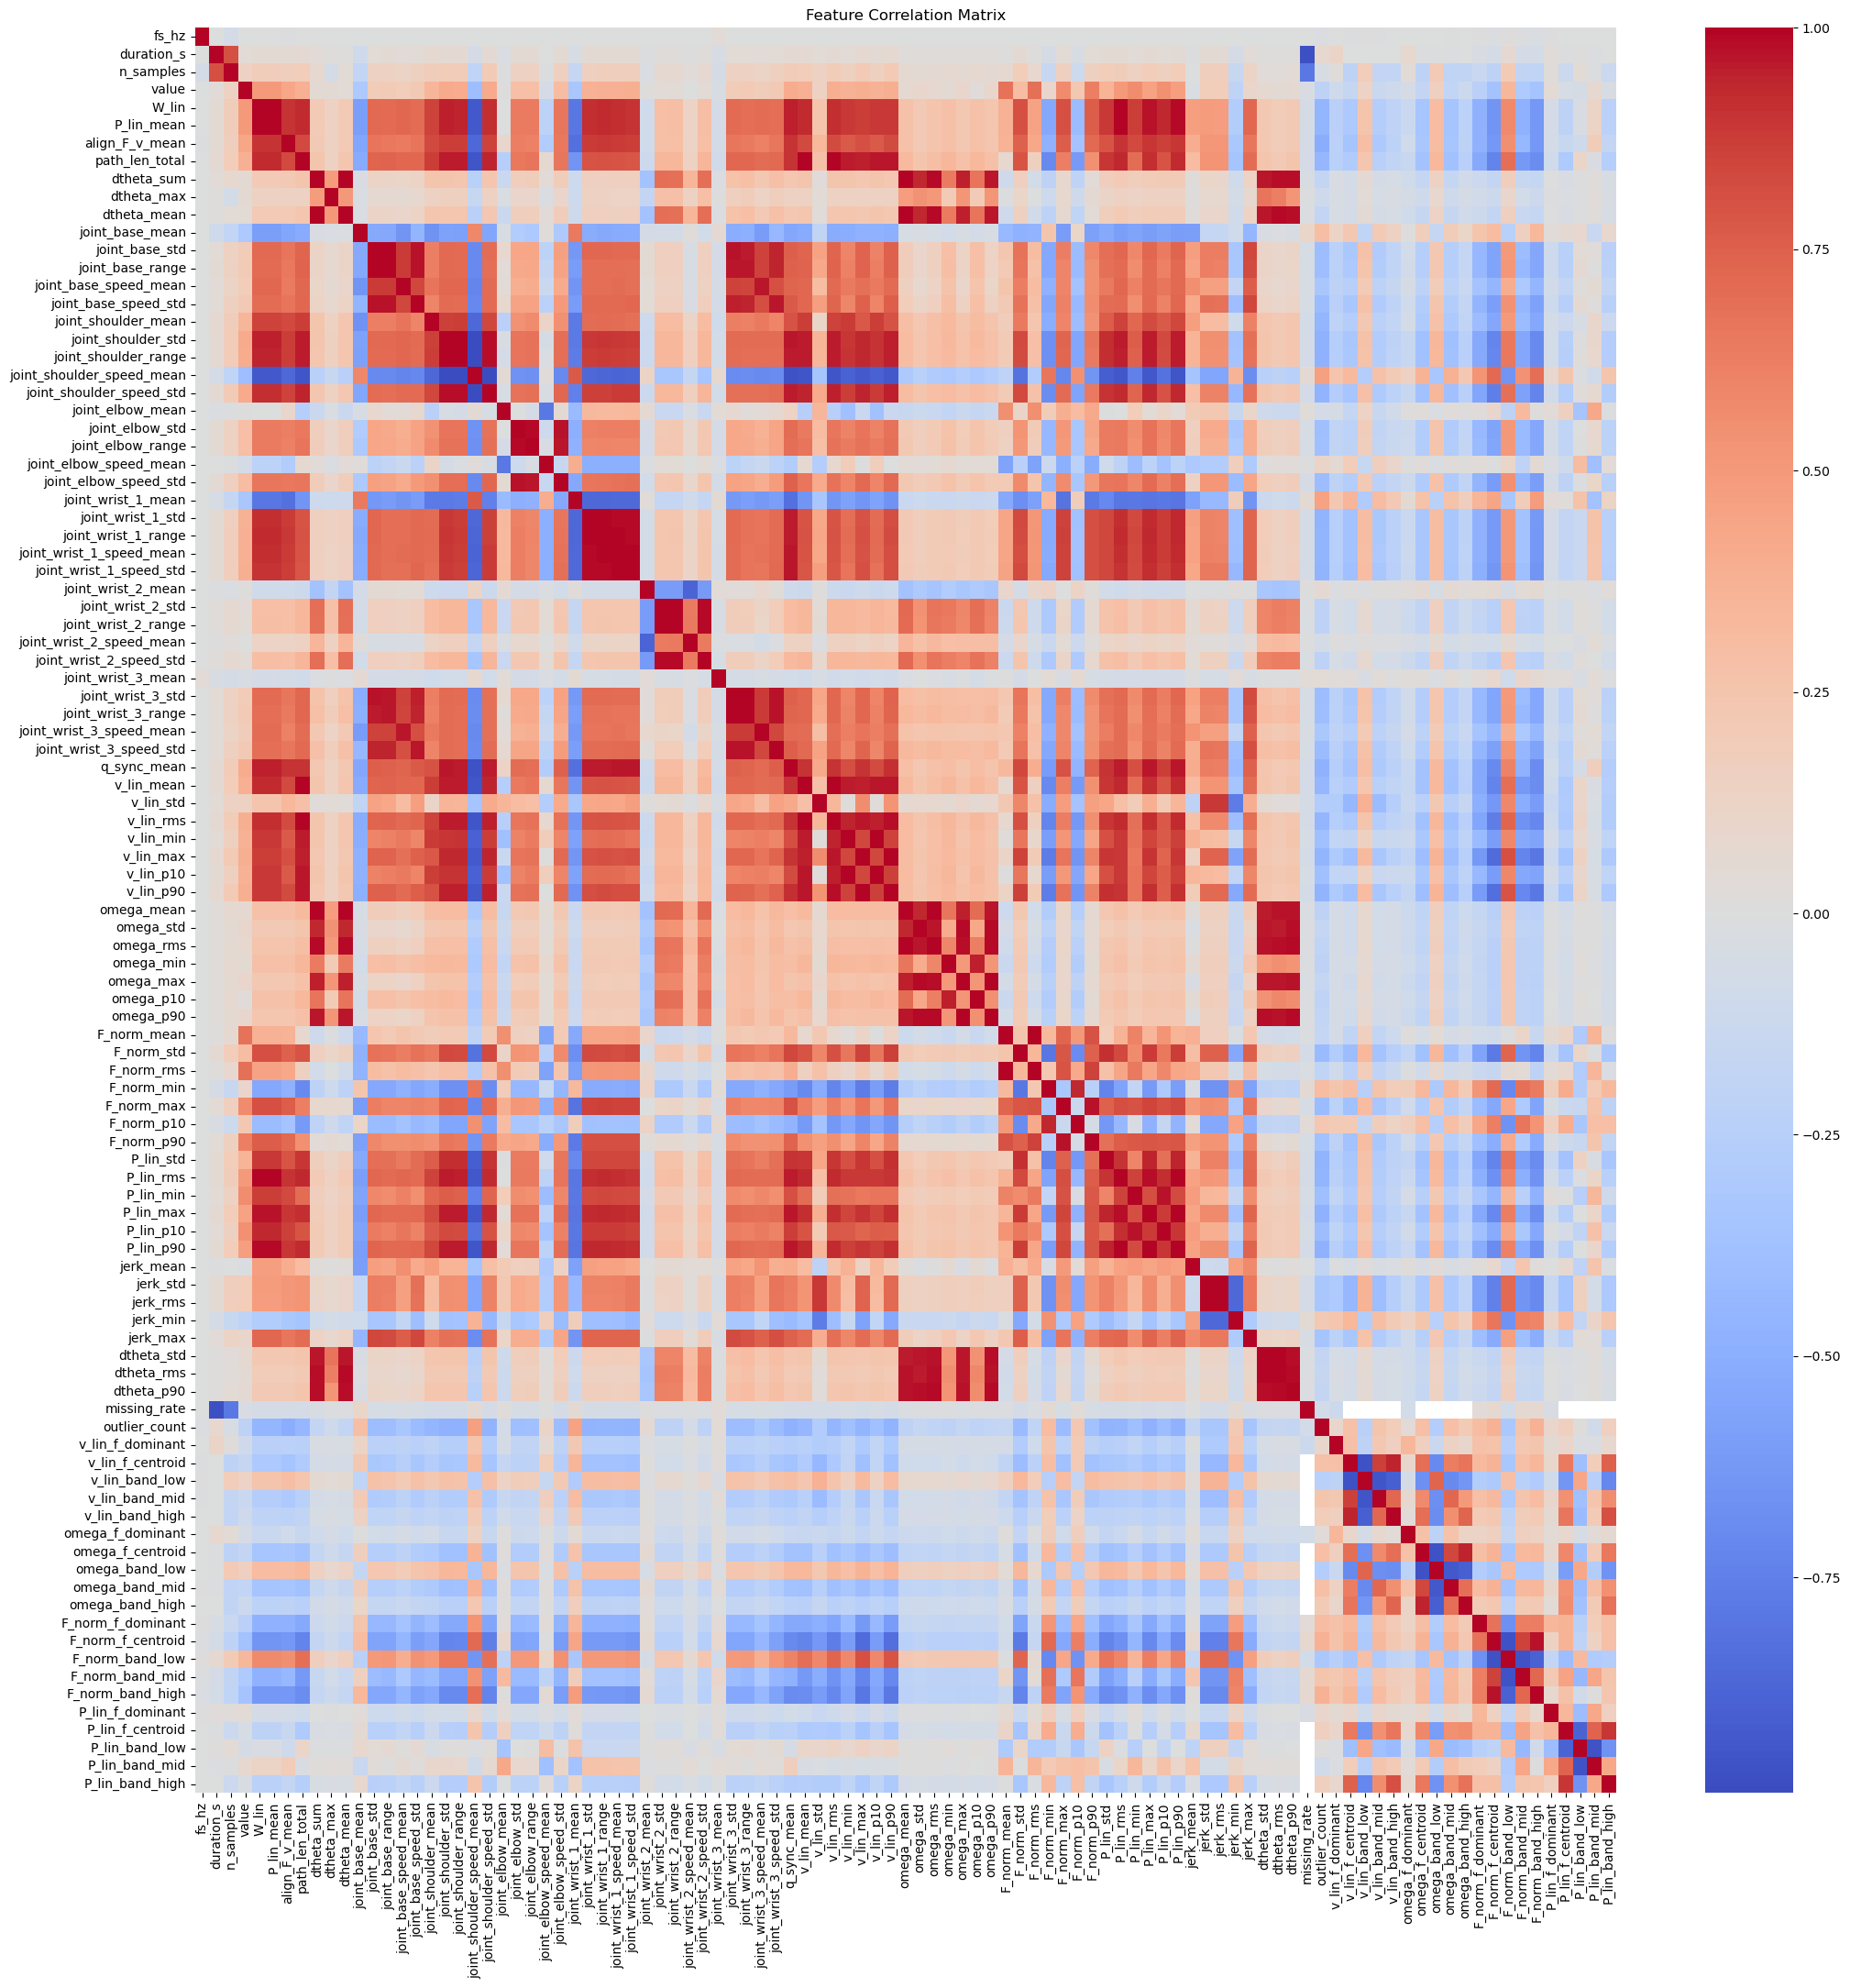

In [5]:
df = df.drop(columns=['sample_id'])
corr_matrix = df.corr()

plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [6]:
value_corr = corr_matrix['value'].drop('value')  # optional: drop self-correlation
value_corr = value_corr.sort_values(ascending=False)
print(value_corr)

F_norm_rms                   0.681674
F_norm_mean                  0.676152
F_norm_p90                   0.624501
F_norm_max                   0.568592
P_lin_min                    0.561028
                               ...   
joint_base_mean             -0.313641
joint_wrist_1_mean          -0.332867
F_norm_band_high            -0.357643
F_norm_f_centroid           -0.370076
joint_shoulder_speed_mean   -0.401464
Name: value, Length: 98, dtype: float64


In [7]:
X = df.drop(columns=["value"])  # Features
y = df["value"]                 # Target

# ==== Train/test split (75/25) ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42  # random_state ensures reproducibility
)

In [8]:
# ==== 1) CV setup: 3-fold with shuffling ====
cv3 = KFold(n_splits=3, shuffle=True, random_state=42)

# ==== 2) Define pipelines ====
base_steps = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
]
linreg_pipe = Pipeline(base_steps + [("model", LinearRegression())])
ridge_pipe  = Pipeline(base_steps + [("model", Ridge())])
lasso_pipe  = Pipeline(base_steps + [("model", Lasso(max_iter=10000))])

# ==== 3) Hyperparameter grids for Ridge/Lasso ====
ridge_grid = {"model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_grid = {"model__alpha": [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]}

# ==== 4) Fit & evaluate ====
def evaluate_model(name, model, Xtr, ytr, Xte, yte, grid=None):
    if grid is None:
        # Linear Regression (no hyperparams): CV scores then fit on full train
        cv_scores = cross_val_score(model, Xtr, ytr, cv=cv3, scoring="r2")
        model.fit(Xtr, ytr)
        best_alpha = None
    else:
        # Grid search (e.g., Ridge/Lasso)
        gs = GridSearchCV(model, param_grid=grid, cv=cv3, scoring="r2", n_jobs=-1, refit=True)
        gs.fit(Xtr, ytr)
        model = gs.best_estimator_
        cv_scores = gs.cv_results_["mean_test_score"][gs.best_index_]
        best_alpha = model.get_params().get("model__alpha", None)

    ypred = model.predict(Xte)
    r2 = r2_score(yte, ypred)
    rmse = mean_squared_error(yte, ypred, squared=False)

    print(f"\n{name}")
    print("-" * len(name))
    if best_alpha is not None:
        print(f" Best alpha: {best_alpha}")
        print(f" CV R² (best): {cv_scores:.3f}")
    else:
        print(f" CV R² (mean over folds): {np.mean(cv_scores):.3f}  ± {np.std(cv_scores):.3f}")
    print(f" Test R²: {r2:.3f}")
    print(f" Test RMSE: {rmse:.4f}")

    return model

lin_model   = evaluate_model("Linear Regression", linreg_pipe, X_train, y_train, X_test, y_test)
ridge_model = evaluate_model("Ridge", ridge_pipe, X_train, y_train, X_test, y_test, grid=ridge_grid)
lasso_model = evaluate_model("Lasso", lasso_pipe, X_train, y_train, X_test, y_test, grid=lasso_grid)

# ==== 5) Pick the best-by-test model (optional) ====
models = {
    "Linear": lin_model,
    "Ridge": ridge_model,
    "Lasso": lasso_model,
}
# Evaluate on test again to select best by R²
scores = {name: r2_score(y_test, mdl.predict(X_test)) for name, mdl in models.items()}
best_name = max(scores, key=scores.get)
best_model = models[best_name]
print(f"\nBest model on the TEST set: {best_name} (R²={scores[best_name]:.3f})")


Linear Regression
-----------------
 CV R² (mean over folds): 0.939  ± 0.003
 Test R²: 0.939
 Test RMSE: 0.0437

Ridge
-----
 Best alpha: 1.0
 CV R² (best): 0.940
 Test R²: 0.940
 Test RMSE: 0.0434

Lasso
-----
 Best alpha: 0.0005
 CV R² (best): 0.931
 Test R²: 0.932
 Test RMSE: 0.0462

Best model on the TEST set: Ridge (R²=0.940)


In [10]:
# --- Pipelines for trees (no scaling needed) ---
rf_pipe   = Pipeline([("imputer", SimpleImputer(strategy="median")),
                      ("model", RandomForestRegressor(random_state=42, n_jobs=-1))])

xgb_pipe  = Pipeline([("imputer", SimpleImputer(strategy="median")),
                      ("model", XGBRegressor(
                          n_estimators=800, learning_rate=0.05, max_depth=7,
                          subsample=0.8, colsample_bytree=0.8, tree_method="hist",
                          random_state=42, n_jobs=-1
                      ))])

# --- Small grid for RandomForest (tunes a bit without being slow) ---
rf_grid = {
    "model__n_estimators": [300, 600, 900],
    "model__max_depth": [None, 8, 12],
    "model__min_samples_leaf": [1, 3, 5],
}

# Reuse your evaluate_model helper from before
rf_model   = evaluate_model("RandomForest", rf_pipe,  X_train, y_train, X_test, y_test, grid=rf_grid)

# For XGB/LGBM we’ll skip grid (good baselines) and just do CV + test like Linear:
def eval_no_grid(name, model, Xtr, ytr, Xte, yte):
    cv_scores = cross_val_score(model, Xtr, ytr, cv=cv3, scoring="r2", n_jobs=-1)
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)
    r2 = r2_score(yte, ypred)
    rmse = mean_squared_error(yte, ypred, squared=False)
    print(f"\n{name}\n" + "-"*len(name))
    print(f" CV R² (mean): {cv_scores.mean():.3f}  ± {cv_scores.std():.3f}")
    print(f" Test R²: {r2:.3f}")
    print(f" Test RMSE: {rmse:.4f}")
    return model

xgb_model  = eval_no_grid("XGBoost",  xgb_pipe,  X_train, y_train, X_test, y_test)

# --- Compare all models (linear + trees) on test ---
models.update({
    "RandomForest": rf_model,
    "XGBoost": xgb_model,
})
scores = {name: r2_score(y_test, mdl.predict(X_test)) for name, mdl in models.items()}
best_name = max(scores, key=scores.get)
print("\n=== TEST SET COMPARISON ===")
for k, v in sorted(scores.items(), key=lambda x: -x[1]):
    print(f"{k:12s} R²={v:.3f}")
print(f"\nBest model on TEST: {best_name} (R²={scores[best_name]:.3f})")


RandomForest
------------
 CV R² (mean over folds): 0.907  ± 0.000
 Test R²: 0.912
 Test RMSE: 0.0526

XGBoost
-------
 CV R² (mean): 0.928  ± 0.010
 Test R²: 0.933
 Test RMSE: 0.0457

=== TEST SET COMPARISON ===
Ridge        R²=0.940
Linear       R²=0.939
XGBoost      R²=0.933
Lasso        R²=0.932
RandomForest R²=0.912

Best model on TEST: Ridge (R²=0.940)


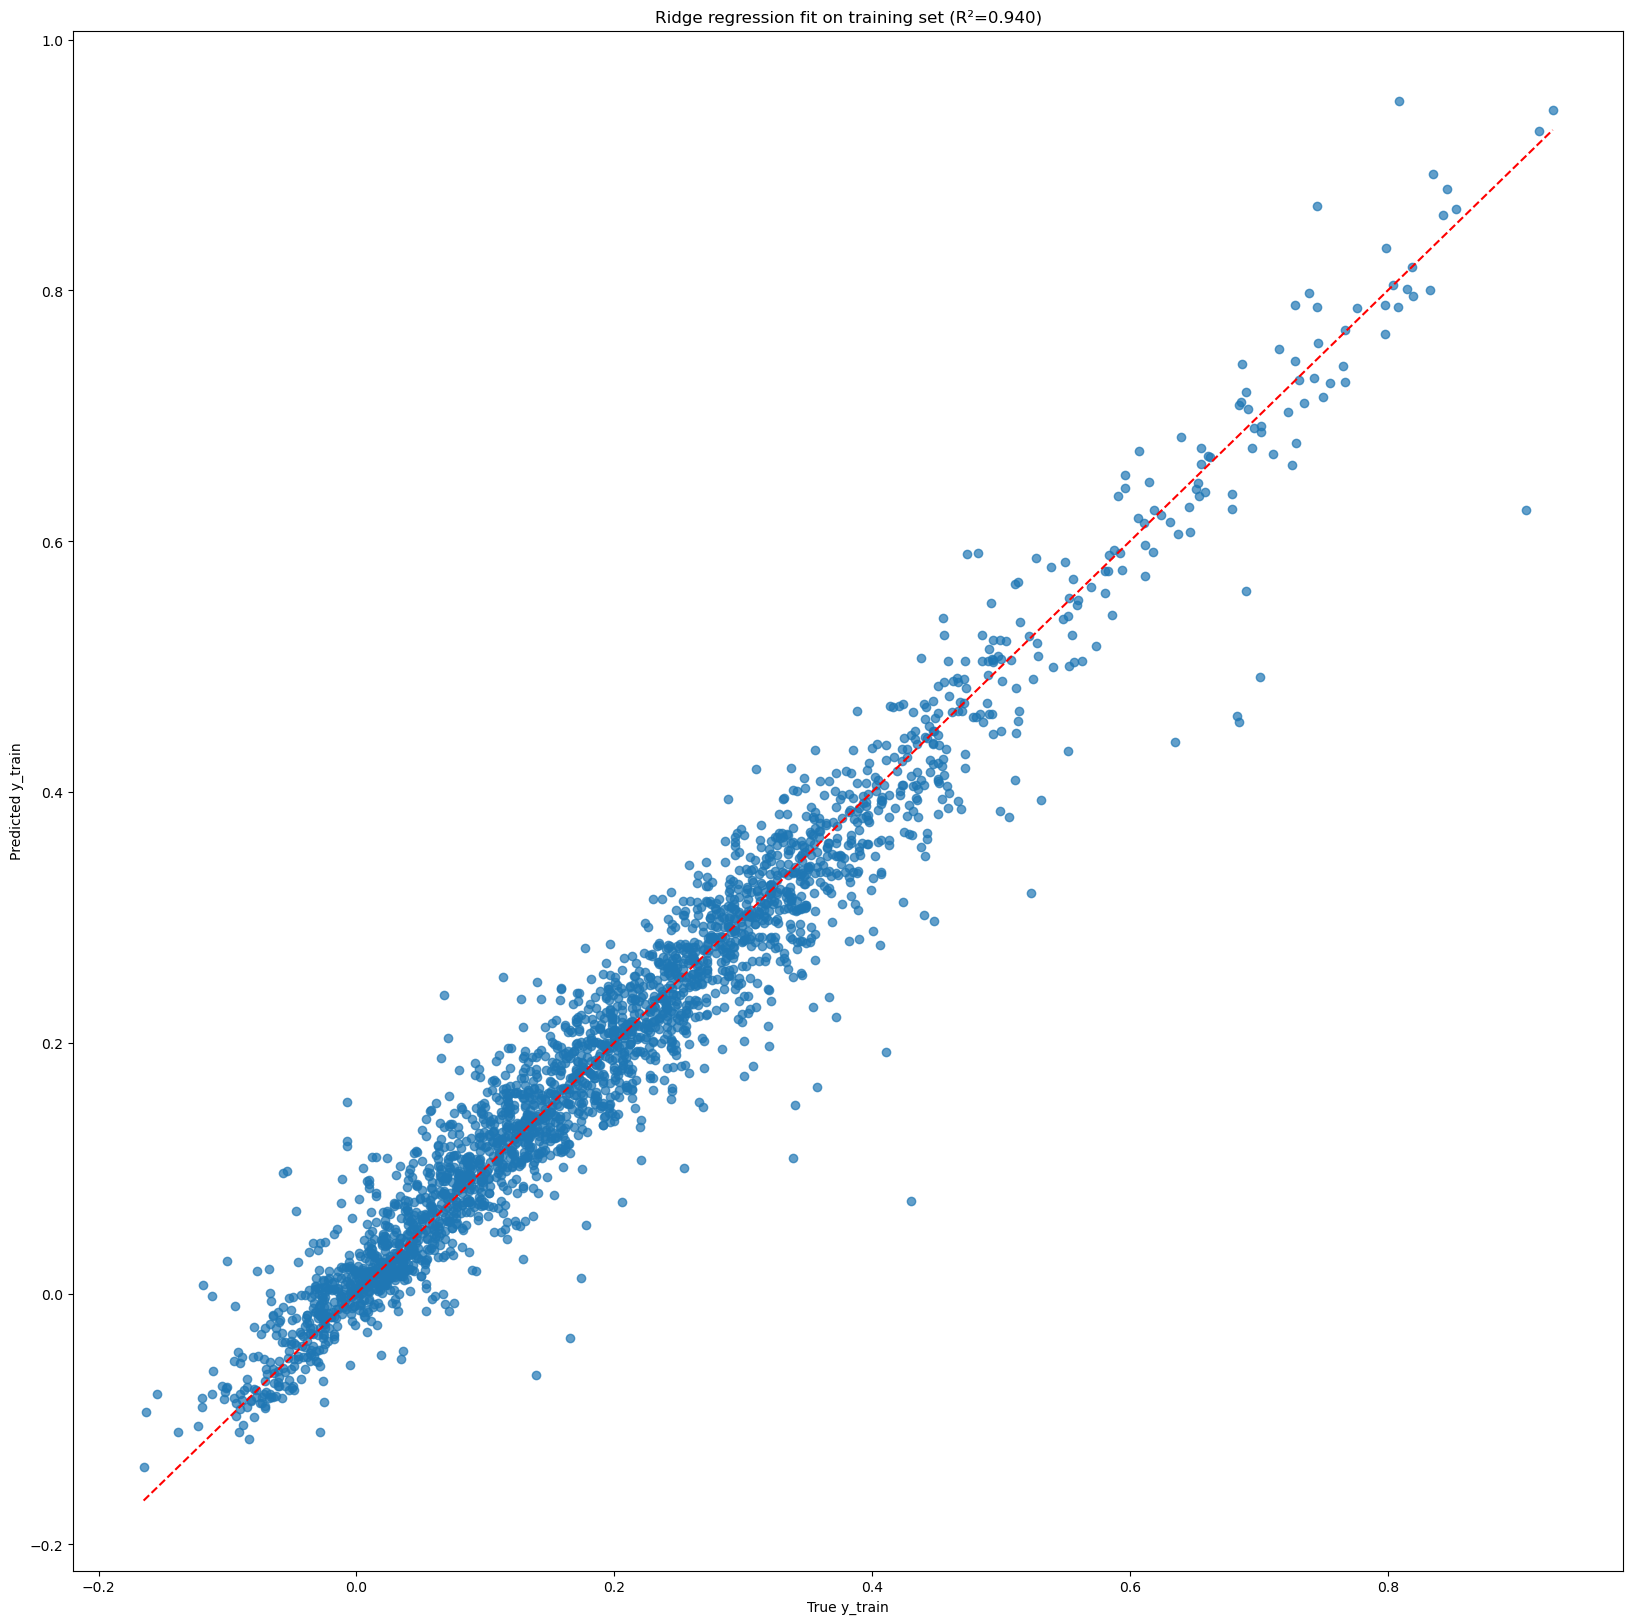

In [13]:
import matplotlib.pyplot as plt

ridge = models["Ridge"]
y_pred = ridge.predict(X_train)

plt.figure(figsize=(20,20))
plt.scatter(y_train, y_pred, alpha=0.7)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()], "r--")  # perfect fit line
plt.xlabel("True y_train")
plt.ylabel("Predicted y_train")
plt.title("Ridge regression fit on training set (R²=0.940)")
plt.show()


In [14]:
# Your starting point
df2 = df.copy()
X = df2.drop(columns=["value"])  # Features
y = df2["value"]                 # Target

# --- Correct scaling of y ---
scaler_y = StandardScaler()

# reshape(-1, 1) required because StandardScaler expects 2D
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# --- Checks ---
print("Original y mean:", y.mean())
print("Original y std :", y.std())

print("Scaled y mean  :", y_scaled.mean())
print("Scaled y std   :", y_scaled.std())

# You can also confirm with scaler attributes
print("Scaler stored mean_ :", scaler_y.mean_)
print("Scaler stored scale_:", scaler_y.scale_)

Original y mean: 0.19169213161659515
Original y std : 0.17383294944901584
Scaled y mean  : -8.945316272802405e-17
Scaled y std   : 1.0
Scaler stored mean_ : [0.19169213]
Scaler stored scale_: [0.17380808]


In [15]:
print(y_test.mean())

0.19432379862700228
